In [1]:
import torchaudio
from transformers import WavLMModel
import torch
import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Load wavlm model

In [2]:
model = WavLMModel.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")

print(model.feature_extractor)
print(model.feature_projection)
print(model.encoder)

# print number of parameters
print('number of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Some weights of WavLMModel were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WavLMFeatureEncoder(
  (conv_layers): ModuleList(
    (0): WavLMGroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)
WavLMFeatureProjection(
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (projection): Linear(in_features=512, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
WavLMEncoder(
  (pos_conv_embed): WavLMPositionalConvEmbedding(
    (conv): ParametrizedConv1d(
      768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16
      (parametrizations): ModuleDi

# Test feature extractor and model output (encoder)

In [3]:
x = torch.randn(1, 16000)

f = model.feature_extractor(x)
print(f.shape)

o = model(x)
print(model.feature_extractor)
y = o.last_hidden_state
print(y.shape)

torch.onnx.export(model.feature_extractor, x, "feature_extractor.onnx")

torch.Size([1, 512, 49])
WavLMFeatureEncoder(
  (conv_layers): ModuleList(
    (0): WavLMGroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)
torch.Size([1, 49, 768])


# Embeddings from feature extractor

In [4]:
def embeddings(pattern):
    files_ = glob.glob(pattern)
    e = []
    for wav in sorted(files_):
        x, fs = torchaudio.load(wav)
        f = model.feature_extractor(x)
        e.append( f.mean(2) )
    return torch.cat(e).detach().numpy()

## Embeddings from feature extractor: gender

(200, 512) (300, 512)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


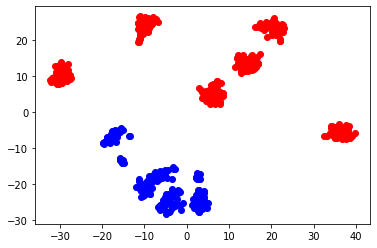

In [5]:
e1 = embeddings('data1/test/*m*2.wav')
e2 = embeddings('data1/test/*f*2.wav')
e = np.concatenate([e1,e2])
print(e1.shape, e2.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[:len(e1),0], et[:len(e1),1], c='b')
plt.scatter(et[len(e1):,0], et[len(e1):,1], c='r')

## Embeddings from feature extractor: speaker

(50, 512) (50, 512) (50, 512) (50, 512)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


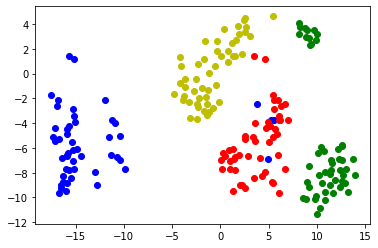

In [6]:
e1 = embeddings('data1/test/*m_51_2.wav')
e2 = embeddings('data1/test/*m_53_2.wav')
e3 = embeddings('data1/test/*m_54_2.wav')
e4 = embeddings('data1/test/*m_55_2.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])
print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

## Embeddings from feature extractor: word

(50, 512) (50, 512) (50, 512) (50, 512)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


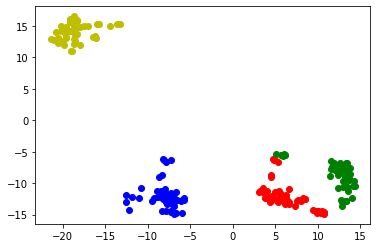

In [7]:
e1 = embeddings('data1/test/*m_51_1.wav')
e2 = embeddings('data1/test/*m_51_2.wav')
e3 = embeddings('data1/test/*m_51_3.wav')
e4 = embeddings('data1/test/*m_51_4.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])

print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

# Embeddings from model output (encoder)

In [8]:
def embeddings2(pattern):
    files_ = glob.glob(pattern)
    e = []
    for wav in sorted(files_):
        x, fs = torchaudio.load(wav)
        o = model(x).last_hidden_state
        e.append( o.mean(1) )
    return torch.cat(e).detach().numpy()

# Embeddings from model output (encoder): gender

(200, 768) (300, 768)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


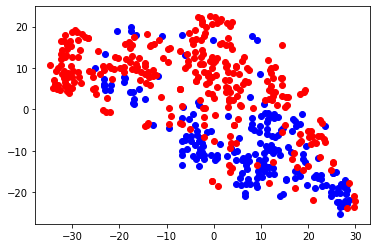

In [9]:
e1 = embeddings2('data1/test/*m*2.wav')
e2 = embeddings2('data1/test/*f*2.wav')
e = np.concatenate([e1,e2])
print(e1.shape, e2.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[:len(e1),0], et[:len(e1),1], c='b')
plt.scatter(et[len(e1):,0], et[len(e1):,1], c='r')

# Embeddings from model output (encoder): speaker

(50, 768) (50, 768) (50, 768) (50, 768)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


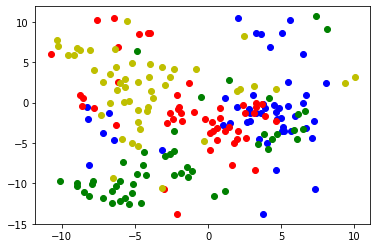

In [10]:
e1 = embeddings2('data1/test/*m_51_2.wav')
e2 = embeddings2('data1/test/*m_53_2.wav')
e3 = embeddings2('data1/test/*m_54_2.wav')
e4 = embeddings2('data1/test/*m_55_2.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])
print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')

# Embeddings from model output (encoder): word

(50, 768) (50, 768) (50, 768) (50, 768)


/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch/cadrete/software/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


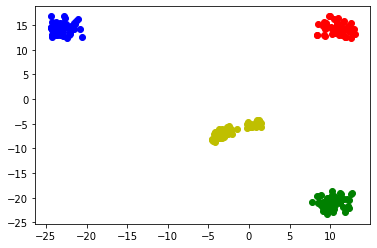

In [11]:
e1 = embeddings2('data1/test/*m_51_1.wav')
e2 = embeddings2('data1/test/*m_51_2.wav')
e3 = embeddings2('data1/test/*m_51_3.wav')
e4 = embeddings2('data1/test/*m_51_4.wav')

e = np.concatenate([e1,e2,e3,e4])
l = np.concatenate([np.zeros(len(e1)), np.ones(len(e2)), np.ones(len(e3))*2, np.ones(len(e4))*3])

print(e1.shape, e2.shape, e3.shape, e4.shape)
et = TSNE(n_components=2).fit_transform(e)
plt.clf()
plt.scatter(et[l==0,0], et[l==1,1], c='b')
plt.scatter(et[l==1,0], et[l==1,1], c='r')
plt.scatter(et[l==2,0], et[l==2,1], c='g')
plt.scatter(et[l==3,0], et[l==3,1], c='y')